# Part I: Assembling a Dataset & Extracting the Features

## Audio Data

The first thing we need in order to create a model for cough detection and monitoring, is the data. 

Two types of audio were sought out in order to form our dataset: 
   1. The first is obviously samples of people coughing. No further label is necessary at this point, however it is useful to include examples of all sexes and ages. 
   2. The second is any type of sound that is not a cough. As the intended implementation of this model is as an overnight monitoring module, sounds that have a high likelyhood of being heard in such a scenario were sought out. These include: random talking, snoring, footsteps, doors & drawers being opened and shut, street noises as recorded from indoors.

An existing snoring dataset was very helpful in assembing our own. A number of audio samples was used from:
T. H. Khan, "A deep learning model for snoring detection and vibration notification using a smart wearable gadget," Electronics, vol. 8, no. 9, article. 987, ISSN 2079-9292, 2019.

All other audio has been obtained from open access sources, extracted from youtube videos, or recorded by the author.

In [1]:
# Import libraries to be used

import numpy as np
from pydub import AudioSegment
import os
from os import walk
import librosa
import librosa.display
import matplotlib.pyplot as plt
from pydub.silence import split_on_silence

The various raw audio files have been stored in two directories named "various cough sounds" and "various non-cough sounds". These files are uneven in length and contain multiple instances of the acoustic events in question. 

A first step we have to take is to split these raw audio files into segments each containing a single event (cough, or a non-cough instance). We chose to save the segments as wav files since they are much more convenient to work with than mp3s.

In [ ]:
def isolate_events(loadpath, savepath, min_silence_len, silence_thresh):
    '''Function to split raw audio into chunks corresponding to isolated events
    takes a specified loading path, a saving path, the minimum silence time length 
    in ms, and the threshold for silence in dB.'''
    
    sound_file = AudioSegment.from_mp3(loadpath)
    
    # split audio
    audio_chunks = split_on_silence(sound_file, 
                                    # must be silent for at least half a second
                                    min_silence_len=min_silence_len,
                                    # consider it silent if quieter than 
                                    silence_thresh=silence_thresh
                                   )
    # store the 
    for i, chunk in enumerate(audio_chunks):

        out_file = savepath+i+".wav"
        print("exporting", out_file)
        chunk.export(out_file, format="wav")

In [ ]:
# Make sure the directories exist to store the segmented audio:
if not os.path.exists("cough_segments"):
    os.makedirs("cough_segments")
if not os.path.exists("nocough_segments"):
    os.makedirs("nocough_segments")

So now we can use the above function to extract audio events from our raw audio files. We will not automate this process further, as each raw audio file requires specific settings for the minimum silence length, and the silence threshold, that are better fine tuned manually.

In [ ]:
# Create cough audio events - or change the paths for the non-coughing events:
LOADPATH = "./various cough sounds/coughing_long (0).mp3"
SAVEPATH = "./cough_segments/cough"
isolate_events(LOADPATH, SAVEPATH, 500, -35)

## Generate Features

So now we have a dataset full of short audio files, each corresponding to a single event (cough or no-cough). 

What is next, is to generate features we can train a model on out of this audio data. A good choice when it comes to human sounds is to use the Mel Frequency Ceptral Coefficients. We will not go into detail on what these are, but librosa has a convenient method to extract and plot these features. The resulting plots will be saved as png images.

An example of an MFCC plot is shown below:

50538

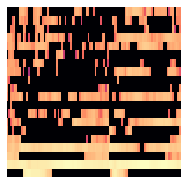

In [11]:
# Check image output

filepath = './cough_segments/cough405.wav'
clip, sample_rate = librosa.load(filepath, sr=None)

# Stretch clip to 1s if too short, or cut it to 2s if too long:
if len(clip) <= sample_rate:
    clip = np.append(clip, np.zeros(sample_rate-len(clip)))
elif len(clip) >= 2 * sample_rate:
    clip = clip[:sample_rate]

# Set up figure:
fig = plt.figure(figsize=[3.12,3.12])  #[3.12,3.12])
ax = fig.add_subplot(111)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_frame_on(False)

# Calculate and plot MFCCs
S = librosa.feature.mfcc(y=clip, sr=sample_rate)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
len(clip)

So this is an example of the MFCC for a cough event. Let's see what it looks like for something that is not a cough:

44100

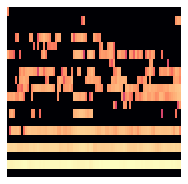

In [10]:
filepath = './nocough_segments/0_200.wav'
clip, sample_rate = librosa.load(filepath, sr=None)
if len(clip) >= sample_rate:
    clip = clip[:sample_rate]
else:
    clip = np.append(clip, np.zeros(sample_rate-len(clip)))
    
fig = plt.figure(figsize=[3.12,3.12])  #[3.12,3.12])
ax = fig.add_subplot(111)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_frame_on(False)

S = librosa.feature.mfcc(y=clip, sr=sample_rate)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
len(clip)

To us humans, and from just two examples, it might seem impossible to differentiate between the two classes. However, given enough input, and with well structured model, we can have a tool to detect patterns and perform the classification task. 

In short, what we are doing is representing sound with pictures. A great deal of the properties that define each audio sample are contained in these MFCC images. Therefore, we can rely on a model that would normally be used to classify images to perform the classification of audio events.

The next step is to create an image dataset out of the audio samples we have extracted, using the MFCC transform.

In [ ]:
# Make sure the directories exist to store the MFCC images:
if not os.path.exists("cough_mfccs_test"):
    os.makedirs("cough_mfccs_test")
if not os.path.exists("nocough_mfccs_test"):
    os.makedirs("nocough_mfccs_test")

The directory paths in following code can be modified to select according to the class:

In [17]:
audio_files = []

# go through the audio files in the desired directory:
for (_,_,filenames) in walk('cough_segments_test'):
    audio_files.extend(filenames)
    break
    
for i, audio_file in enumerate(audio_files):
    
    # read audio samples
    input_data, sample_rate = librosa.load("cough_segments_test/"+audio_file, sr=None)
    
    # ensure sample is of a reasonable length between 1 and 2 s:
    if len(input_data) >= sample_rate:
        input_data = input_data[:sample_rate]
    else:
        input_data = np.append(input_data, np.zeros(sample_rate-len(input_data)))
    
    # define figure parameters
    fig = plt.figure(figsize=[3.12,3.12])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)

    # calculate MFCCs and generate plot
    S = librosa.feature.mfcc(y=input_data, sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))

    # store the MFCC image
    plt.savefig("cough_mfccs_test/cough_test" + str(i) + '.png')

    plt.close('all')

So by now we should have an image dataset of two classes, corresponding to cough and no-cough audio events. Using this data as input to our machine learning model, we should be able to train it so that it can detect coughing in an input audio stream.

This is the end of Part I, see Part II in the second Notebook, where we compile and train our model using the features we just created.